## TUIA - Aprendizaje Automático 1

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian



El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [59]:
!pip install pandas
!pip install scikit-learn
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

## Importar el dataset

In [61]:
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',')

## Filtramos por las ciudades de interés

In [62]:
ciudades = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']
df = df[df['Location'].isin(ciudades)]

## Realizamos el split de entrenamiento y prueba 

Tomamos la decición de separar por fecha para evitar la fuga de datos al momento de imputar los faltantes, ya que los vamos a reemplazar por datos de esa misma fecha de las otras localidades, por lo cual si estos datos estuviesen en el conjunto de test no los deberiamos usar

In [63]:
test_size = 0.20
train_size = 1 - test_size

total_rows = len(df)
num_test_rows = int(total_rows * test_size)
num_train_rows = int(total_rows * train_size)
train = df.iloc[:num_train_rows]
test = df.iloc[num_train_rows:]
print(train.iloc[-1])
print(test.iloc[0])

print('Total rows: ' + str(total_rows))
print('Total num_test_rows: ' + str(num_test_rows))
print('Total num_train_rows: ' + str(num_train_rows))

Unnamed: 0               96903
Date                2010-02-04
Location              Adelaide
MinTemp                   21.9
MaxTemp                   29.6
Rainfall                   1.0
Evaporation                5.4
Sunshine                   7.3
WindGustDir                 SW
WindGustSpeed             52.0
WindDir9am                  SW
WindDir3pm                 WSW
WindSpeed9am               9.0
WindSpeed3pm              20.0
Humidity9am               72.0
Humidity3pm               51.0
Pressure9am             1008.7
Pressure3pm             1008.1
Cloud9am                   NaN
Cloud3pm                   NaN
Temp9am                   24.3
Temp3pm                   27.6
RainToday                   No
RainTomorrow                No
RainfallTomorrow           0.0
Name: 96872, dtype: object
Unnamed: 0               96904
Date                2010-02-05
Location              Adelaide
MinTemp                   15.4
MaxTemp                   24.4
Rainfall                   0.0
Evaporation 

## Análisis descriptivo

Se realizará un análisis exploratorio del conjunto de datos de entrenamiento para entender sus características principales y determinar si se requiere alguna acción para abordar datos faltantes, valores atípicos, la codificación de variables categóricas u otros procesos antes de proceder.

In [64]:
train.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

### 

In [65]:
train.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0


In [66]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 22586 entries, 6047 to 96872
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        22586 non-null  int64  
 1   Date              22586 non-null  object 
 2   Location          22586 non-null  object 
 3   MinTemp           22019 non-null  float64
 4   MaxTemp           22033 non-null  float64
 5   Rainfall          21690 non-null  float64
 6   Evaporation       19954 non-null  float64
 7   Sunshine          17716 non-null  float64
 8   WindGustDir       21010 non-null  object 
 9   WindGustSpeed     21012 non-null  float64
 10  WindDir9am        21268 non-null  object 
 11  WindDir3pm        22179 non-null  object 
 12  WindSpeed9am      22239 non-null  float64
 13  WindSpeed3pm      22259 non-null  float64
 14  Humidity9am       21661 non-null  float64
 15  Humidity3pm       21708 non-null  float64
 16  Pressure9am       21755 non-null  float64


Unnamed: 0             0
Date                   0
Location               0
MinTemp              567
MaxTemp              553
Rainfall             896
Evaporation         2632
Sunshine            4870
WindGustDir         1576
WindGustSpeed       1574
WindDir9am          1318
WindDir3pm           407
WindSpeed9am         347
WindSpeed3pm         327
Humidity9am          925
Humidity3pm          878
Pressure9am          831
Pressure3pm          819
Cloud9am            6649
Cloud3pm            6832
Temp9am              580
Temp3pm              569
RainToday            896
RainTomorrow         895
RainfallTomorrow     895
dtype: int64

### **Hay un total de 22586 datos de entrenamiento, 25 columnas y se puede observar que hay datos nulos en la mayoria de las variables.**

### Eliminamos la columna 'Unnamed: 0' y 'Location'
Eliminamos la columna Location debido a la cercania entre ciudades, vamos a considerarlas todas como una sola

In [67]:
train = train.drop(columns=['Unnamed: 0', 'Location'])

### Cambiamos los valores nulos
El criterio es reemplazrlo por de otro de la misma fecha, la anterior o posterior. Debido a la cercania geografica suponemos que no va a existir mucha variacion en las condiciones climaticas

In [68]:
train.sort_values(by='Date', inplace=True)

for column in train.columns:
    train[column] = train[column].ffill()
    train[column] = train[column].bfill()


In [69]:
train.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

### Eliminamos la columna Date:
La razon es que ya no la vamos a usar, solo la usamos como criterio para el reemplazo de los valores nulos

In [70]:
train = train.drop(columns=['Date'])

In [71]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

## Creacion de columnas 
Con el objetivo de reducir la cantidad de columnas y mejorar la explicabilidad del modelo, decidimos agrupar las variables que representan dos momentos del día en una sola columna.

In [72]:
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
train['PressureVariation'] = train['Pressure3pm'] - train['Pressure9am']
train['TempVariation'] = train['Temp3pm'] - train['Temp9am']
train['HumidityVariation'] = train['Humidity3pm'] - train['Humidity9am']
train['CloudVariation'] = train['Cloud3pm'] - train['Cloud9am']
train['WindSpeedVariation'] = train['WindSpeed3pm'] - train['WindSpeed9am']
train.drop(columns=columns_to_aggregate, inplace=True)


In [73]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow', 'RainfallTomorrow', 'PressureVariation',
       'TempVariation', 'HumidityVariation', 'CloudVariation',
       'WindSpeedVariation'],
      dtype='object')

### Estadística descriptiva de las variables numéricas
Examinamos medidas estadísticas, incluyendo valores mínimos, máximos, cuartiles, y medidas de centralidad como la mediana y la media.

In [74]:
train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,RainfallTomorrow,PressureVariation,TempVariation,HumidityVariation,CloudVariation,WindSpeedVariation
count,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000
mean,11.488444,22.127181,2.081484,4.995072,6.885358,42.451740,2.090206,-2.186545,5.046139,-18.701541,0.051005,4.835783
std,5.920697,6.681602,6.635359,3.677518,3.859320,14.452024,6.677779,2.090987,3.487204,15.854864,2.671070,9.435870
min,-8.000000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,-13.400000,-12.100000,-82.000000,-8.000000,-46.000000
25%,7.500000,16.900000,0.000000,2.400000,3.800000,31.000000,0.000000,-3.500000,2.700000,-29.000000,-1.000000,-1.000000
50%,11.200000,21.300000,0.000000,4.200000,7.500000,41.000000,0.000000,-2.400000,4.700000,-18.000000,0.000000,4.000000
75%,15.700000,26.400000,0.800000,6.800000,10.000000,50.000000,0.800000,-1.000000,7.300000,-9.000000,1.000000,11.000000
max,33.900000,46.800000,119.400000,86.200000,14.300000,122.000000,119.400000,20.000000,23.000000,76.000000,8.000000,52.000000


Al analizar las columnas, se percibe que tanto la media como la mediana muestran una cercanía notable, lo que sugiere una tendencia consistente en los datos. Los desvíos en la dispersión de los datos no son extremos y la distribución no presentaria una gran extensión en un boxplot.

Los valores mínimos y máximos registrados estan considerablemente alejados de los valores centrales, lo cual señala la posible existencia de valores atípicos dentro del conjunto de datos.

### **Bloxplot**

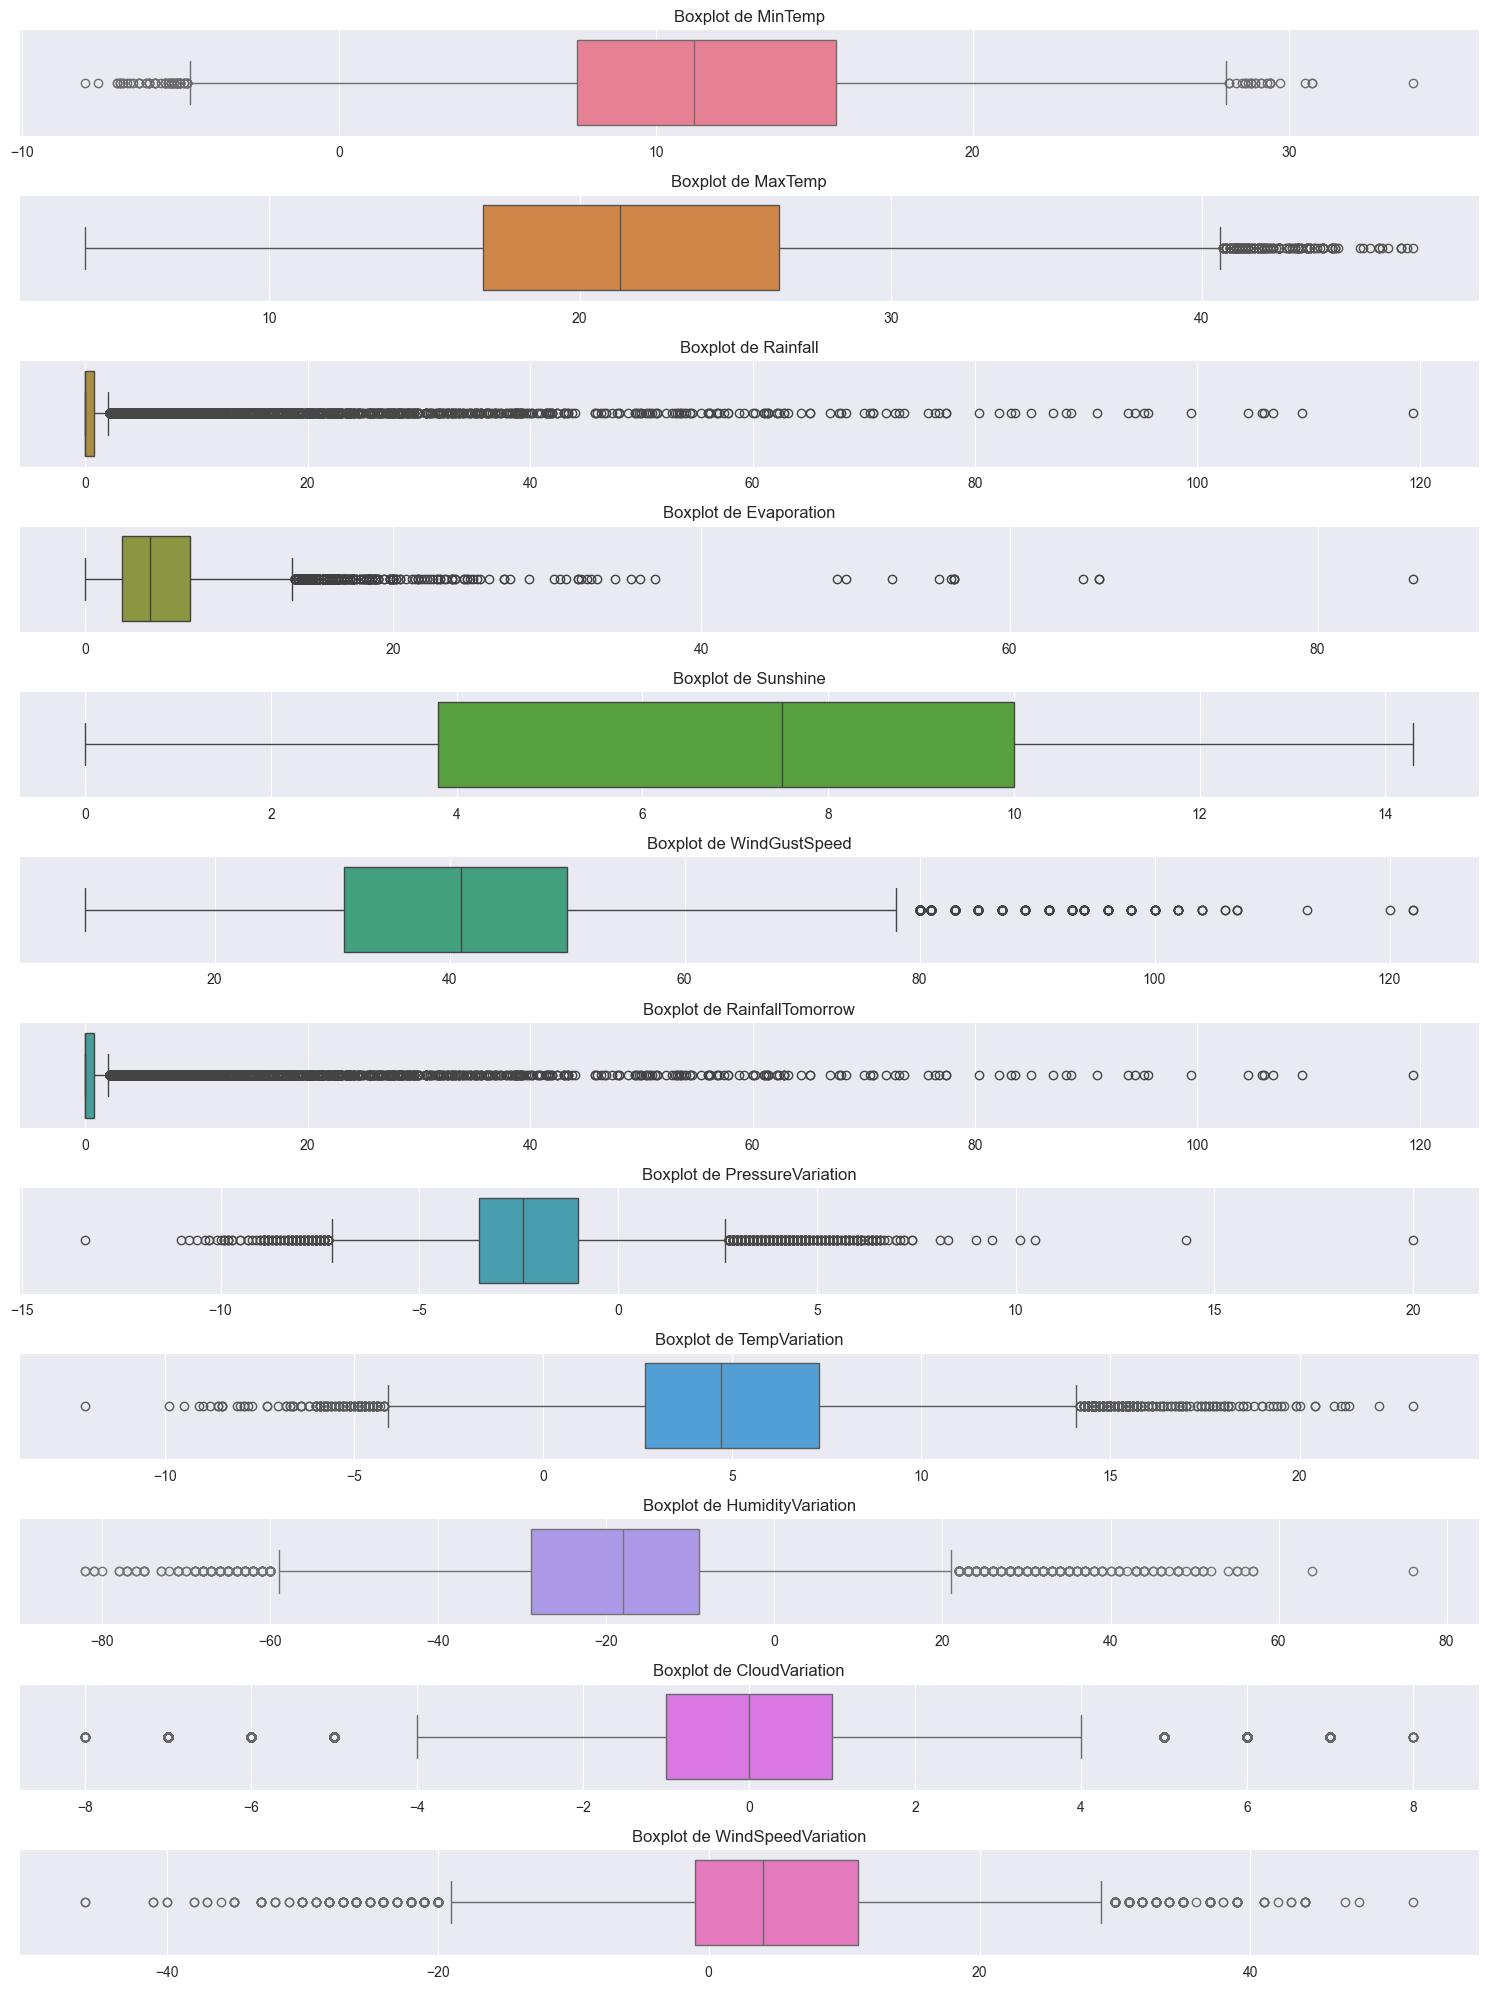

In [75]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

colores = sns.color_palette('husl', n_colors=len(numeric_columns))

fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(15, 20), sharex=False)

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=train, x=col, ax=axes[i], color=colores[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('')

plt.tight_layout()

plt.show()

## Histograma

In [76]:
train['RainToday'] = train['RainToday'].map({'No': 0, 'Yes': 1})
train['RainTomorrow'] = train['RainTomorrow'].map({'No': 0, 'Yes': 1})

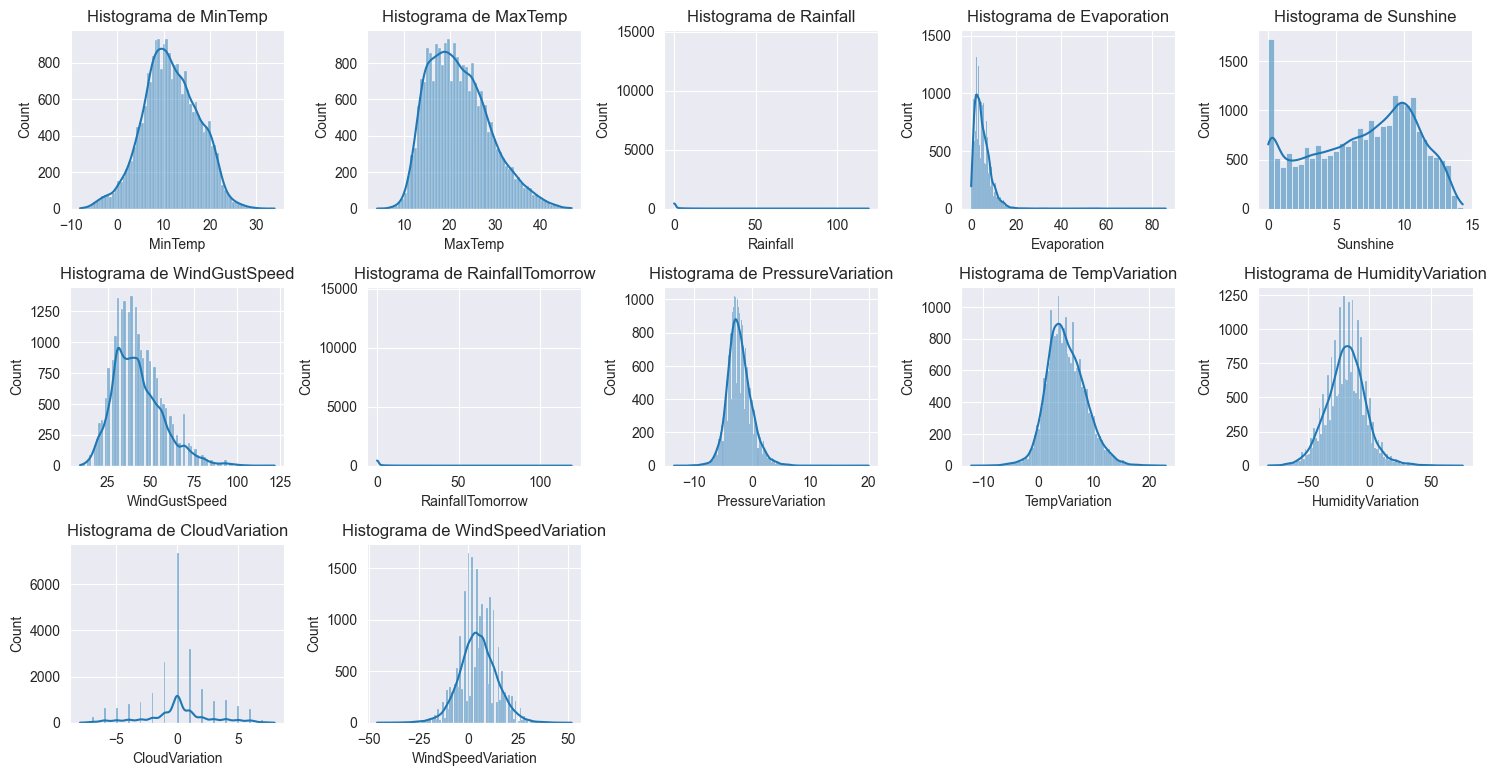

In [77]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(train[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()

Para comprender más a fondo el comportamiento de los datos, empleamos histogramas donde se puede apreciar que algunas variables exhiben una distribución más uniforme de sus valores, como es el caso de la temperatura, humedad y presión. Por otro lado, existen variables que muestran la presencia de múltiples modas en los datos y una distribución menos uniforme.

Asimismo, se destaca que la variable Rainfall concentra la gran mayoría de sus datos en cero.

### Analizamos nuestra variable objetivo, la que queremos predecir para saber si el dataset esta balanceado o no.

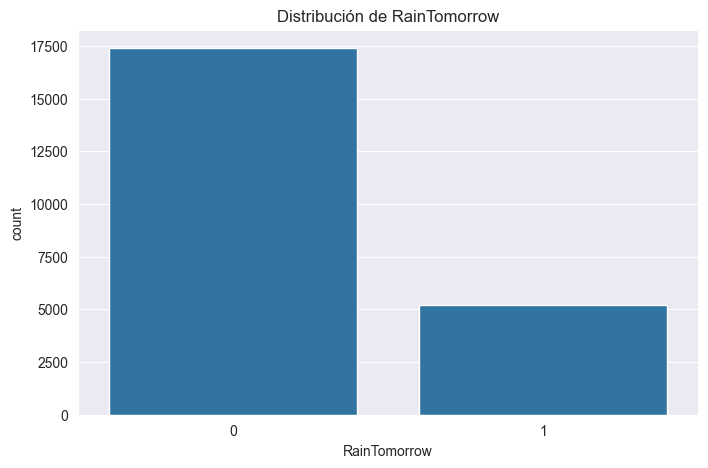

In [78]:
plt.figure(figsize=(8, 5))
sns.countplot(x='RainTomorrow', data=train)
plt.title('Distribución de RainTomorrow')
plt.show()

### Se observa que hay una mayor cantidad de datos donde no llueve(0) comparado con los días que llueve (1). Esto puede hacer que el modelo sea mejor para predecir dias en los que no llueva. Por esta razón, podemos decir que los datos no se encuentran balanceados.
Podemos ver una relacion 3 a 1 aproximadamente, en este caso existen las posibilidad de balanciar el dataset mediante el submuestro o el sobre muestro (preguntar)

# Matriz de correlación 

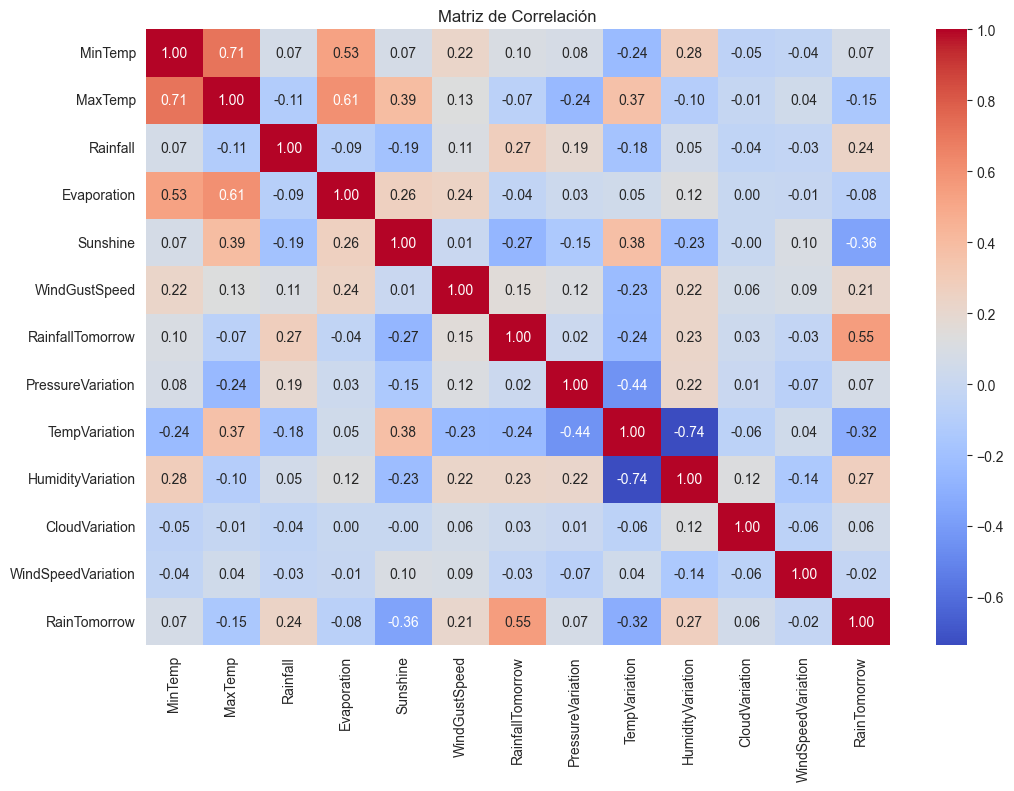

In [79]:
numeric_columns = numeric_columns.append(pd.Index(['RainTomorrow']))
correlation_matrix_numeric = train[numeric_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Podemos observar que las variables con mayor correlación con RainfallTomorrow son:

*   HumidityVariation (0.23)
*   Rainfall (0.27)
*   Cloud3pm (0.25)
*   WindGustSpeed (0.15)
*   MinTemp       (0.10)

y las variables con mayor correlación con RainTomorrow son:

*   HumidityVariation (0,27)
*   RainfallTomorrow (0.55)
*   WindGustSpeed (0,21)
*   Rainfall (0.24)

## Método LinearRegression

Para poder ver las metricas de test necesitamos aplicarle los mismos los cambios que se hicieron en train.

In [80]:
test.sort_values(by='Date', inplace=True)
missing_values = test.isnull().sum()
print("Número de valores faltantes en y_test:", missing_values)
for column in test.columns:
    test[column] = test[column].ffill()
    test[column] = test[column].bfill()
    
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
test = test.drop(columns=['Unnamed: 0', 'Location','Date'])
test['PressureVariation'] = test['Pressure3pm'] - test['Pressure9am']
test['TempVariation'] = test['Temp3pm'] - test['Temp9am']
test['HumidityVariation'] = test['Humidity3pm'] - test['Humidity9am']
test['CloudVariation'] = test['Cloud3pm'] - test['Cloud9am']
test['WindSpeedVariation'] = test['WindSpeed3pm'] - test['WindSpeed9am']
test.drop(columns=columns_to_aggregate, inplace=True)
test['RainToday'] = test['RainToday'].map({'No': 0, 'Yes': 1})
test['RainTomorrow'] = test['RainTomorrow'].map({'No': 0, 'Yes': 1})


Número de valores faltantes en y_test: Unnamed: 0             0
Date                   0
Location               0
MinTemp                3
MaxTemp                5
Rainfall              90
Evaporation         1721
Sunshine            1843
WindGustDir           69
WindGustSpeed         68
WindDir9am           330
WindDir3pm            30
WindSpeed9am          11
WindSpeed3pm          13
Humidity9am           15
Humidity3pm           12
Pressure9am            8
Pressure3pm           10
Cloud9am            2718
Cloud3pm            2718
Temp9am                5
Temp3pm                7
RainToday             90
RainTomorrow          90
RainfallTomorrow      90
dtype: int64


/var/folders/ln/x3fdm6713xnc3v3rj1lh2nyc0000gn/T/ipykernel_1543/488707974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_values(by='Date', inplace=True)
/var/folders/ln/x3fdm6713xnc3v3rj1lh2nyc0000gn/T/ipykernel_1543/488707974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[column] = test[column].ffill()
/var/folders/ln/x3fdm6713xnc3v3rj1lh2nyc0000gn/T/ipykernel_1543/488707974.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [81]:
# Seleccionar las variables predictoras (características) y la variable de respuesta (y) para ambos conjuntos
X_train = train.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_train = train['RainfallTomorrow']
y_train_clasification =train['RainTomorrow']
X_test = test.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_test_clasification = test['RainTomorrow']
y_test = test['RainfallTomorrow']

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones sobre los datos de entrenamiento y de prueba
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calcular métricas sobre los datos de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Calcular métricas sobre los datos de prueba
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 36.77686013196486
R-squared (Train): 0.1752356960728182
Mean Absolute Error (MAE) (Train): 2.886736668393842
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 20.39145823327724
R-squared (Test): 0.17912138938230682
Mean Absolute Error (MAE) (Test): 2.478697518406641
Mean Absolute Percentage Error (MAPE) (Test): inf


## Método de gradiente descendiente

In [82]:
sgd_model = SGDRegressor(loss='squared_error', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = sgd_model.predict(X_train)
y_pred_test = sgd_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)

Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 53.49355596701245
R-squared (Train): -0.19965585135355068
Mean Absolute Error (MAE) (Train): 3.49368410510246
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 31.91270267233445
R-squared (Test): -0.2846778651646851
Mean Absolute Error (MAE) (Test): 3.0473181188923757
Mean Absolute Percentage Error (MAPE) (Test): inf


## Métodos de regularización Lasso

In [83]:
# Crear y entrenar el modelo Lasso
lasso_model = Lasso(alpha=0.1)  # alpha es el parámetro de regularización
lasso_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 36.87182324748212
R-squared (Train): 0.17310603661882173
Mean Absolute Error (MAE) (Train): 2.861366911483362
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 20.6041701731043
R-squared (Test): 0.17055845682351212
Mean Absolute Error (MAE) (Test): 2.4694089655114966
Mean Absolute Percentage Error (MAPE) (Test): inf


# Regresion de Ridge

In [84]:
# Crear y entrenar el modelo Ridge
ridge_model = Ridge(alpha=0.1)  # alpha es el parámetro de regularización
ridge_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 36.776860132126195
R-squared (Train): 0.1752356960692001
Mean Absolute Error (MAE) (Train): 2.886735752938646
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 20.39146178773171
R-squared (Test): 0.1791212462941758
Mean Absolute Error (MAE) (Test): 2.4786970234241794
Mean Absolute Percentage Error (MAPE) (Test): inf


## Método de regularización Elasticnet

In [85]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha es el parámetro de regularización, l1_ratio controla la proporción de L1 y L2
elastic_net_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = elastic_net_model.predict(X_train)
y_pred_test = elastic_net_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)

Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 36.81892259493171
R-squared (Train): 0.17429239591435353
Mean Absolute Error (MAE) (Train): 2.868562292251006
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 20.506627828331812
R-squared (Test): 0.17448512177984987
Mean Absolute Error (MAE) (Test): 2.4697778971405597
Mean Absolute Percentage Error (MAPE) (Test): inf


## Regresión Logística

In [86]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model.predict(X_train)
y_pred_test = logistic_model.predict(X_test)

# Calcular métricas
accuracy_train = accuracy_score(y_train_clasification, y_pred_train)
accuracy_test = accuracy_score(y_test_clasification, y_pred_test)
precision_train = precision_score(y_train_clasification, y_pred_train)
precision_test = precision_score(y_test_clasification, y_pred_test)
recall_train = recall_score(y_train_clasification, y_pred_train)
recall_test = recall_score(y_test_clasification, y_pred_test)
f1_train = f1_score(y_train_clasification, y_pred_train)
f1_test = f1_score(y_test_clasification, y_pred_test)

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Accuracy (Train):", accuracy_train)
print("Precision (Train):", precision_train)
print("Recall (Train):", recall_train)
print("F1 Score (Train):", f1_train)

print("\nMétricas sobre los datos de prueba:")
print("Accuracy (Test):", accuracy_test)
print("Precision (Test):", precision_test)
print("Recall (Test):", recall_test)
print("F1 Score (Test):", f1_test)

Métricas sobre los datos de entrenamiento:
Accuracy (Train): 0.8218365359071992
Precision (Train): 0.6887738595923649
Recall (Train): 0.4101329223656328
F1 Score (Train): 0.5141270224583434

Métricas sobre los datos de prueba:
Accuracy (Test): 0.8083938374358066
Precision (Test): 0.7497116493656286
Recall (Test): 0.429042904290429
F1 Score (Test): 0.5457598656591099


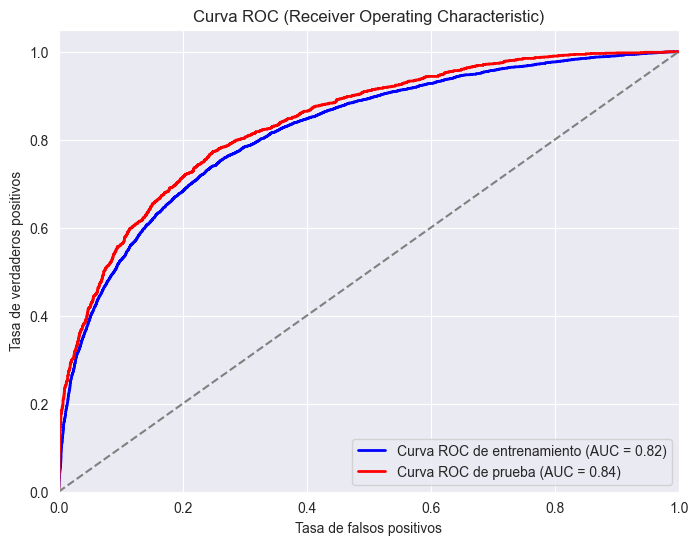

In [87]:
# Obtener las probabilidades de predicción de la clase positiva para entrenamiento y prueba
y_pred_proba_train = logistic_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = logistic_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC para entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test_clasification, y_pred_proba_test)

# Calcular el área bajo la curva ROC (AUC) para entrenamiento y prueba
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Trazar las curvas ROC para entrenamiento y prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Curva ROC de entrenamiento (AUC = %0.2f)' % auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Curva ROC de prueba (AUC = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

## Modelo Clasificar base 

In [88]:
from sklearn.dummy import DummyClassifier

# Crear el clasificador ingenuo que predice la clase mayoritaria
naive_classifier = DummyClassifier(strategy="most_frequent")

# Entrenar el modelo con los datos de entrenamiento
naive_classifier.fit(X_train, y_train_clasification)

# Hacer predicciones sobre los datos de entrenamiento y prueba
y_pred_train = naive_classifier.predict(X_train)
y_pred_test = naive_classifier.predict(X_test)

# Evaluar la precisión del modelo en los datos de entrenamiento
accuracy_train = accuracy_score(y_train_clasification, y_pred_train)
print("Precisión del modelo ingenuo en datos de entrenamiento:", accuracy_train)

# Evaluar la precisión del modelo en los datos de prueba
accuracy_test = accuracy_score(y_test_clasification, y_pred_test)
print("Precisión del modelo ingenuo en datos de prueba:", accuracy_test)


Precisión del modelo ingenuo en datos de entrenamiento: 0.7701673603116975
Precisión del modelo ingenuo en datos de prueba: 0.7317159553745352


## curva ROC de modelo base

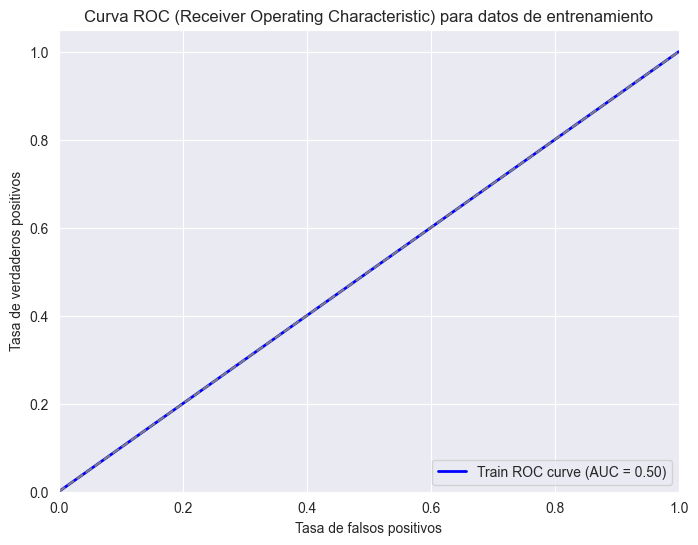

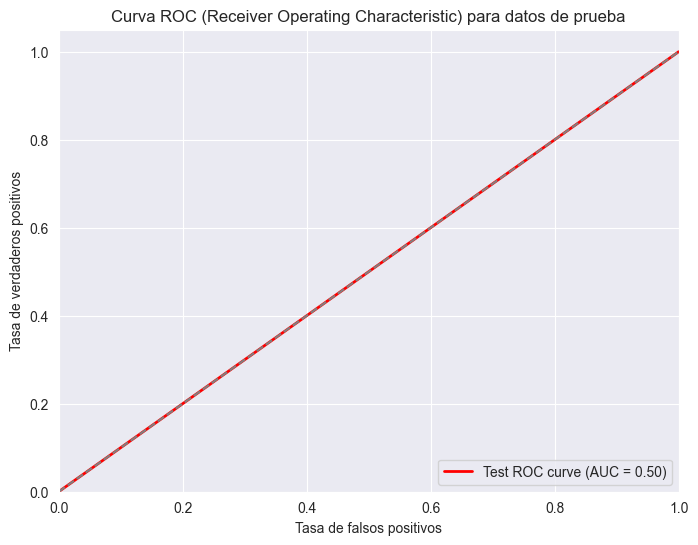

In [89]:
# Obtener las probabilidades de predicción de la clase positiva (la clase mayoritaria)
y_pred_proba_train = np.full_like(y_train_clasification, fill_value=1)  # Clase mayoritaria
y_pred_proba_test = np.full_like(y_test_clasification, fill_value=1)  # Clase mayoritaria

# Calcular la curva ROC para los datos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test_clasification, y_pred_proba_test)

# Calcular el área bajo la curva ROC (AUC) para los datos de entrenamiento y prueba
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Trazar la curva ROC para los datos de entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (AUC = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic) para datos de entrenamiento')
plt.legend(loc='lower right')
plt.show()

# Trazar la curva ROC para los datos de prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (AUC = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic) para datos de prueba')
plt.legend(loc='lower right')
plt.show()

## Modelo Regresion base 

In [90]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Crear un DummyRegressor que predice la media de la variable objetivo
dummy_regressor = DummyRegressor(strategy='mean')

# Entrenar el modelo de regresión base con los datos de entrenamiento
dummy_regressor.fit(X_train, y_train)

# Hacer predicciones con el modelo de regresión base en los datos de entrenamiento y prueba
y_pred_train_base = dummy_regressor.predict(X_train)
y_pred_test_base = dummy_regressor.predict(X_test)

# Calcular el error cuadrático medio (MSE) del modelo de regresión base para el conjunto de entrenamiento y prueba
mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base = mean_squared_error(y_test, y_pred_test_base)

# Calcular el Error Absoluto Medio (MAE) para el conjunto de entrenamiento y prueba
mae_train_base = mean_absolute_error(y_train, y_pred_train_base)
mae_test_base = mean_absolute_error(y_test, y_pred_test_base)

# Calcular el Error Porcentual Absoluto Medio (MAPE) para el conjunto de prueba
mape_test_base = np.mean(np.abs((y_test - y_pred_test_base) / y_test)) * 100

# Calcular el coeficiente de determinación (R-cuadrado) para el conjunto de prueba
r2_test_base = r2_score(y_test, y_pred_test_base)

# Imprimir las métricas
print("Métricas para el modelo de regresión base:")
print("Error cuadrático medio (MSE) (Train):", mse_train_base)
print("Error cuadrático medio (MSE) (Test):", mse_test_base)
print("Mean Absolute Error (MAE) (Train):", mae_train_base)
print("Mean Absolute Error (MAE) (Test):", mae_test_base)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_base)
print("R-squared (Test):", r2_test_base)


Métricas para el modelo de regresión base:
Error cuadrático medio (MSE) (Train): 44.59075151149107
Error cuadrático medio (MSE) (Test): 24.89062714405437
Mean Absolute Error (MAE) (Train): 3.153872799256599
Mean Absolute Error (MAE) (Test): 2.753289667271957
Mean Absolute Percentage Error (MAPE) (Test): inf
R-squared (Test): -0.001997169288790124
